# Detectron2 Detect Chess Detection

<img src="chest.JPG" />

In this exercise, we will see how to finetune a model to adapt it to a specific task.

We are going to use a pretrain model for a new task: Chess detection.

> ⚠️⚠️ **Important**: Run this notebook on Google Colab, with GPU enabled.

> ⚠️ In this exercise, we gave you some pieces of code that you need to complete : look for the `# TODO`

## Introduction to fine-tuning a model

## Get data

In [1]:
!pip install pyyaml==5.1

# install detectron from source
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

# torch
import torch
print(torch.__version__, torch.cuda.is_available())

# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 4.7 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2_repo'...
remote: Enumerating objects: 15725, done.
remote: Counting objects: 100% (448/448), done.
remote: Compressing objects: 100% (337/337), done.
remote: Total 15725 (delta 201), reused 301 (delta 102), pack-reused 15277
Receiving objects: 100% (15725/15725), 6.51 MiB | 4.79 MiB/s, done.
Resolving deltas: 100% (11317/11317), done.
Obtaining file:///content/detectron2_repo
  Preparing metadata (setup.p

2.3.0+cu121 True


In [ ]:
#%load_ext tensorboard
#%tensorboard --logdir output

In [3]:
!pip install --upgrade setuptools
!pip install lxml

  Using cached setuptools-70.0.0-py3-none-any.whl (863 kB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


In [ ]:
##!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

Before we can start training our model we need to download our data-set. In this case we will use my microcontroller detection data-set, which is [available on Kaggle](https://www.kaggle.com/tannergi/microcontroller-detection).

In [5]:
# Install Kaggle API
!pip install -q kaggle
##!pip install -q kaggle-cli

In [6]:
!pip install -q kaggle-cli

  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for lxml
ERROR: Could not build wheels for lxml, which is required to install pyproject.toml-based projects


In order to use the Kaggle’s public API, you must first authenticate using an API token. From the site header, click on your user profile picture, then on “My Account” from the dropdown menu. This will take you to your account settings at https://www.kaggle.com/account. Scroll down to the section of the page labelled API:

To create a new token, click on the “Create New API Token” button. This will download a fresh authentication token onto your machine. Copy your username and the key generated in the kaggle.json file and use it to complete the code snippet given below.

In [7]:
import os
os.environ['KAGGLE_USERNAME'] = "faivmike"
os.environ['KAGGLE_KEY'] = "88a83ca9d059e2ee360a8219a2d1dc78"

In [8]:
!kaggle datasets download -d tannergi/chess-piece-detection

Dataset URL: https://www.kaggle.com/datasets/tannergi/chess-piece-detection
License(s): Attribution 4.0 International (CC BY 4.0)
 99% 165M/166M [00:08<00:00, 24.0MB/s]
100% 166M/166M [00:08<00:00, 20.6MB/s]


In [9]:
!unzip chess-piece-detection.zip

Archive:  chess-piece-detection.zip
  inflating: Chess Detection/annotations/IMG_1989.xml  
  inflating: Chess Detection/annotations/IMG_1990.xml  
  inflating: Chess Detection/annotations/IMG_1991.xml  
  inflating: Chess Detection/annotations/IMG_1992.xml  
  inflating: Chess Detection/annotations/IMG_1993.xml  
  inflating: Chess Detection/annotations/IMG_1994.xml  
  inflating: Chess Detection/annotations/IMG_1995.xml  
  inflating: Chess Detection/annotations/IMG_1996.xml  
  inflating: Chess Detection/annotations/IMG_1997.xml  
  inflating: Chess Detection/annotations/IMG_1998.xml  
  inflating: Chess Detection/annotations/IMG_1999.xml  
  inflating: Chess Detection/annotations/IMG_2000.xml  
  inflating: Chess Detection/annotations/IMG_2001.xml  
  inflating: Chess Detection/annotations/IMG_2002.xml  
  inflating: Chess Detection/annotations/IMG_2003.xml  
  inflating: Chess Detection/annotations/IMG_2004.xml  
  inflating: Chess Detection/annotations/IMG_2005.xml  
  inflating:

## Register data-set

In order to use a dataset with Detectron2 we need to register it. For more information check out the [official documentation](https://detectron2.readthedocs.io/tutorials/datasets.html#register-a-dataset).

In [10]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools
import cv2
import xml.etree.ElementTree as ET


# we give you a function that loads the dataset into detectron2's standard format
def get_dataset_dicts(annotation_path, image_path):
    classes = ['white-rook', 'white-knight', 'white-bishop', 'white-king', 'white-queen', 'white-pawn', 'black-rook', 'black-knight', 'black-bishop', 'black-king', 'black-queen', 'black-pawn']

    dataset_dicts = []
    for filename in os.listdir(annotation_path):
        record = {}
        root = ET.parse(os.path.join(annotation_path, filename)).getroot()
        record["file_name"] = os.path.join(image_path, root.find('filename').text)
        record["height"] = 2248
        record["width"] = 4000

        objs = []
        for member in root.findall('object'):
          obj = {
              'bbox': [int(member[4][0].text), int(member[4][1].text), int(member[4][2].text), int(member[4][3].text)],
              'bbox_mode': BoxMode.XYXY_ABS,
              'category_id': classes.index(member[0].text),
              "iscrowd": 0
          }
          objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [11]:
from detectron2.data import DatasetCatalog, MetadataCatalog

classes = ['white-rook', 'white-knight', 'white-bishop', 'white-king', 'white-queen', 'white-pawn', 'black-rook', 'black-knight', 'black-bishop', 'black-king', 'black-queen', 'black-pawn']

DatasetCatalog.register('chess_piece_dataset', lambda: get_dataset_dicts('Chess Detection/annotations', 'Chess Detection/images'))
MetadataCatalog.get('chess_piece_dataset').set(thing_classes=classes)
chess_metadata = MetadataCatalog.get('chess_piece_dataset')

We can check if our code works correctly by plotting a few images with visualizer

# Q1 . Display few images

We can use :  
    - dataset_dicts = DatasetCatalog.get('chess_piece_dataset')  
in order to get the dataset

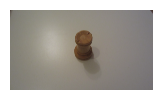

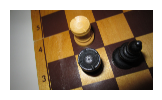

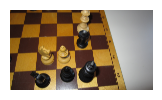

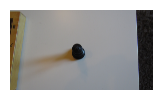

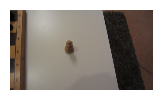

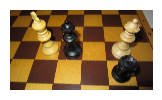

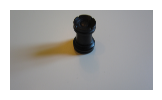

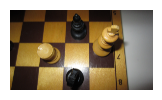

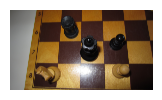

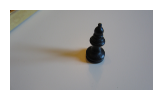

In [17]:
import random
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt

fig = plt.figure()

dataset_dicts = DatasetCatalog.get('chess_piece_dataset')
for i, d in enumerate(random.sample(dataset_dicts, 10)):
    # TODO : write code to display images
    # use Visualizer
    #print(d)
    img_filename = d['file_name']
    img = plt.imread(img_filename)
    plt.subplot(4, 3, i+1)
    plt.axis('off')
    plt.imshow(img)
    plt.show()



# Q2 . Train model

### load configuration

In order to fine tune modal you have to :
- select a pretraining model
- define dataset.train and dataset.test
- define number of classes

In [19]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ('chess_piece_dataset',)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.MAX_ITER = 1000
## 6 different types of pieces * 2 colors = 12 classes
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 12

### Then load the model (same a DefaultPredictor but you have to use DefaultTrainer)

In [20]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) ## cf the import above

[06/07 14:01:25 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [21]:
### TODO : finally, run the training.
## https://medium.com/red-buffer/training-an-object-detection-model-in-a-few-minutes-using-detectron2-5bd0aa5550d4
trainer.resume_or_load(resume=False)
trainer.train()

[06/07 14:05:08 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl ...


model_final_f6e8b1.pkl: 243MB [00:06, 35.7MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[06/07 14:05:15 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/07 14:05:38 d2.utils.events]:  eta: 0:13:47  iter: 19  total_loss: 1.999  loss_cls: 1.523  loss_box_reg: 0.4813  loss_rpn_cls: 0.01618  loss_rpn_loc: 0.01165    time: 0.8810  last_time: 0.7412  data_time: 0.1415  last_data_time: 0.0160   lr: 0.00039962  max_mem: 3507M
[06/07 14:05:59 d2.utils.events]:  eta: 0:13:08  iter: 39  total_loss: 1.077  loss_cls: 0.5488  loss_box_reg: 0.5091  loss_rpn_cls: 0.001044  loss_rpn_loc: 0.007515    time: 0.8775  last_time: 0.8704  data_time: 0.1097  last_data_time: 0.0645   lr: 0.00079922  max_mem: 3508M
[06/07 14:06:18 d2.utils.events]:  eta: 0:13:06  iter: 59  total_loss: 1.022  loss_cls: 0.468  loss_box_reg: 0.5447  loss_rpn_cls: 0.0002074  loss_rpn_loc: 0.009919    time: 0.9025  last_time: 1.3564  data_time: 0.1637  last_data_time: 0.4828   lr: 0.0011988  max_mem: 3508M
[06/07 14:06:38 d2.utils.events]:  eta: 0:12:51  iter: 79  total_loss: 0.952  loss_cls: 0.4263  loss_box_reg: 0.5186  loss_rpn_cls: 0.0001123  loss_rpn_loc: 0.00656    time: 0.

# Q3. Use model for inference

Now, we can perform inference on our validation set by creating a predictor object.

The model is saved if the cfg.OUTPUT_DIR path

### Q3.1 : print cfg.OUTPUT_DIR

In [22]:
# TODO : print cfg.OUTPUT_DIR
print(f'cfg.OUTPUT_DIR: {cfg.OUTPUT_DIR}')

cfg.OUTPUT_DIR: ./output


### Q3.2 : change cfg.MODEL.WEIGHTS with the path of the model save

In [23]:
### https://github.com/facebookresearch/detectron2/issues/1258
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # TODO : path to model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("chess_piece_dataset", )
predictor = DefaultPredictor(cfg)

[06/07 14:25:35 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


### Q3.3 : display prediction

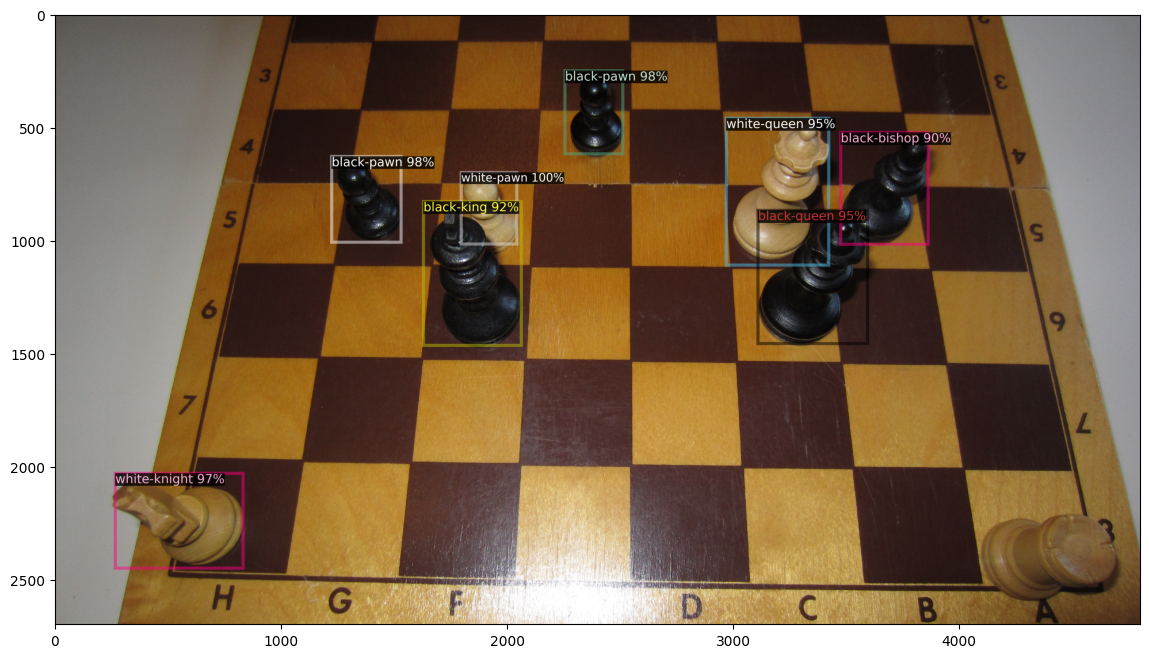

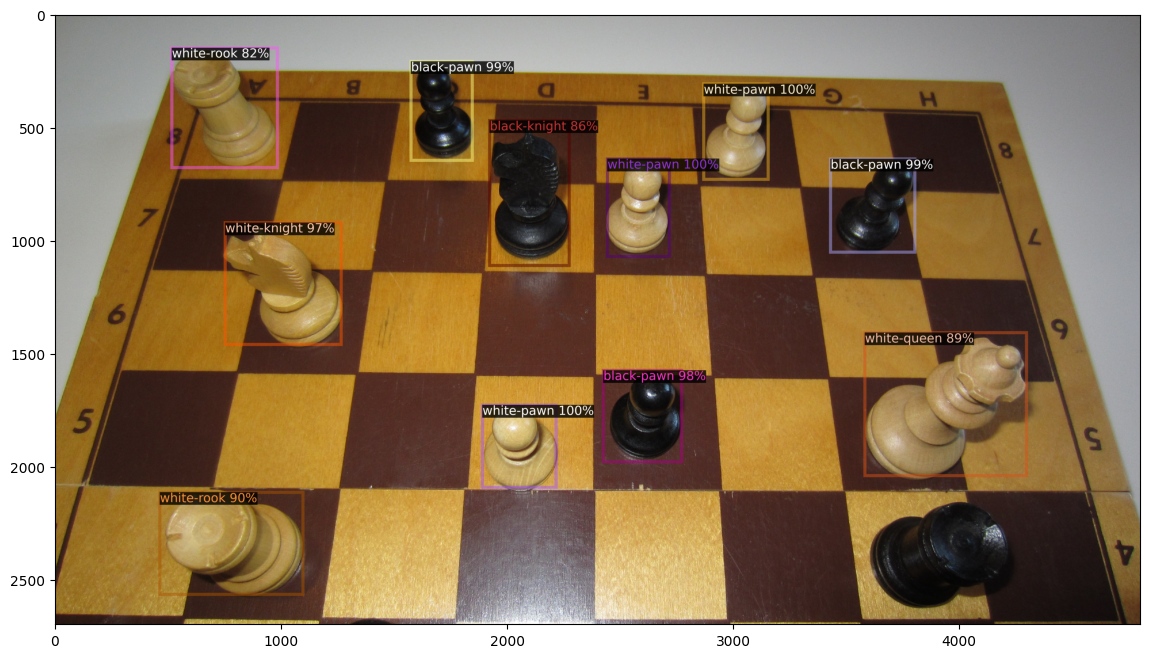

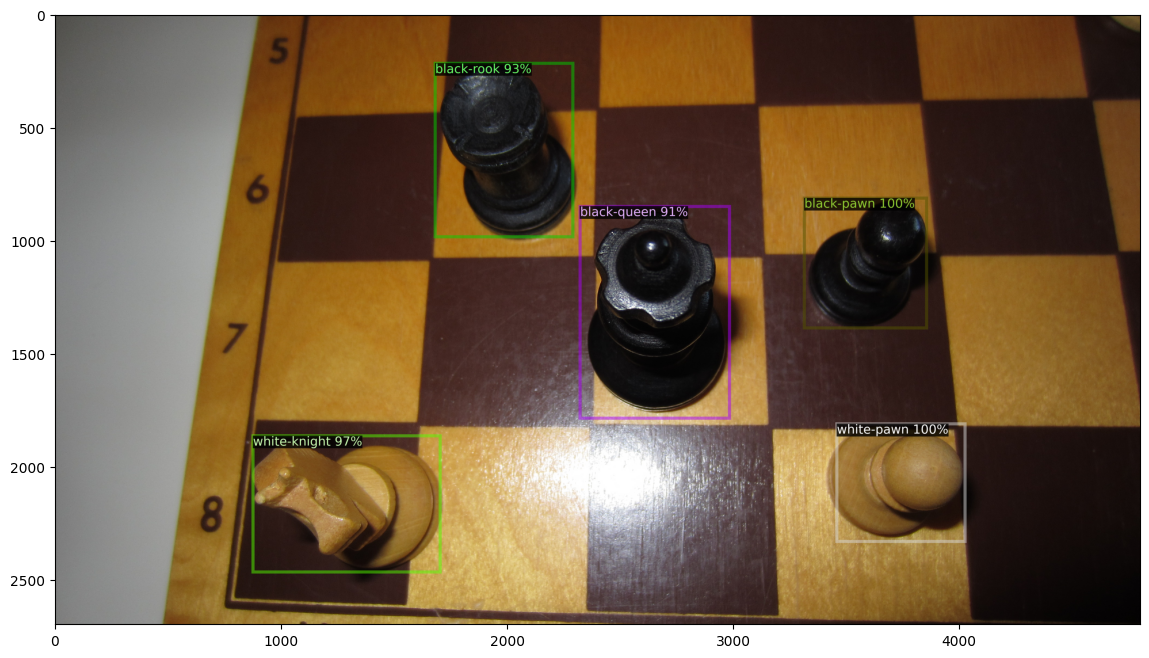

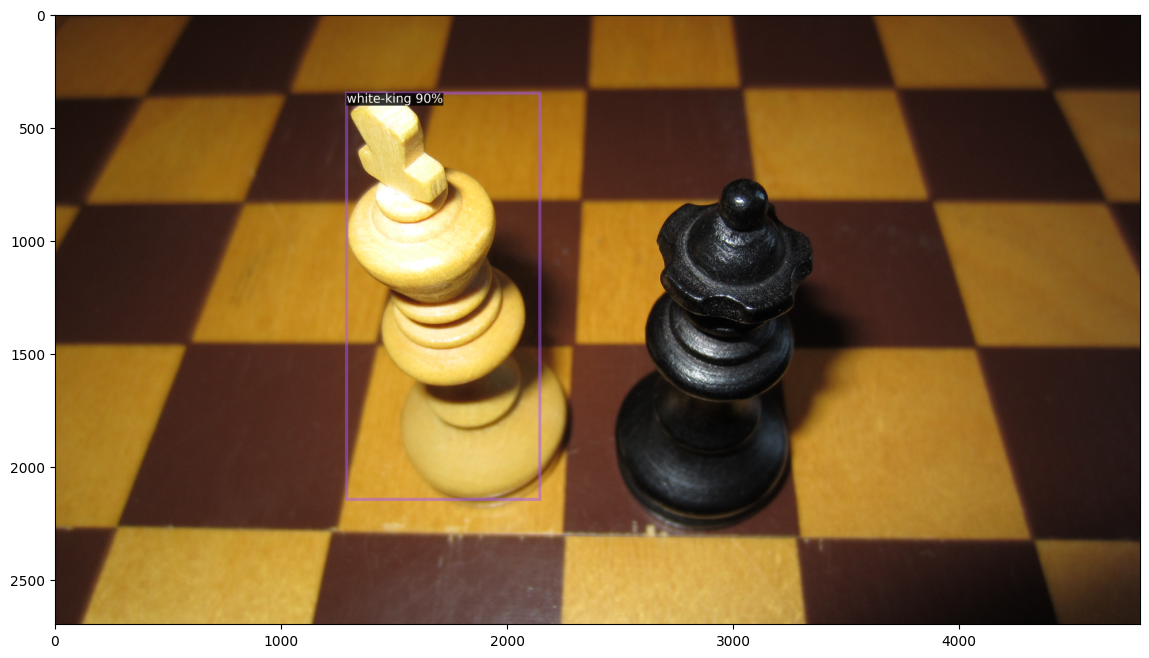

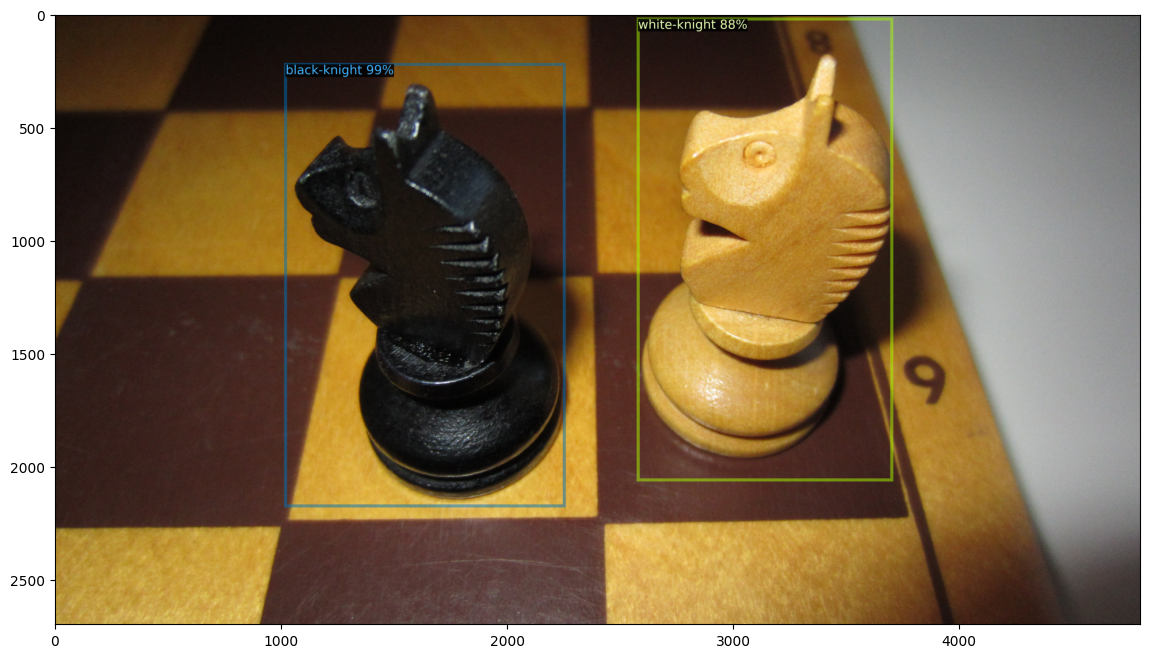

In [24]:
from detectron2.utils.visualizer import ColorMode
import random
import cv2

## voir le cours sur get_cfg
dataset_dicts = DatasetCatalog.get('chess_piece_dataset')
for d in random.sample(dataset_dicts, 5):
    # TODO : get image, predict and display prediction
    # Make prediction on current image
    img_filename = d['file_name']
    img = cv2.imread(img_filename)
    outputs = predictor(img)
    ## Visualizer is a class that allow us to easily visualize the predictions and the results.
    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    ## plot chess image and detectron2
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()